# Sparse Identification of Nonlinear Dynamical systems (SINDy) 

Source: [PySINDy Examples](https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy/example.html)

In [ ]:
!pip install pysindy
!pip install cvxpy

## SINDy Main Ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

### Differentiation Functions Available

PySINDy has the following implementations of differentiation functions:

* `FiniteDifference` - First order (forward difference) or second order (centered difference) finite difference methods with the ability to drop endpoints. Does *not* assume a uniform time step. Appropriate for smooth data.
* `finite_difference` - Central finite differences of any order. Assumes a uniform time step. Appropriate for smooth data.
* `Smoothed Finite Difference` - `FiniteDifference` with a smoother (default is Savitzky Golay) applied to the data before differentiation. Appropriate for noisy data.
* `savitzky_golay` - Perform a least-squares fit of a polynomial to the data, then compute the derivative of the polynomial. Appropriate for noisy data.
* `spline` - Fit the data with a spline (of arbitrary order) then perform differentiation on the spline. Appropriate for noisy data.
* `trend_filtered` - Use total squared variations to fit the data (computes a global derivative that is a piecewise combination of polynomials of a chosen order). Set `order=0` to obtain the total-variational derivative. Appropriate for noisy data
* `spectral` - Compute the spectral derivative of the data via Fourier Transform. Appropriate for very smooth (i.e. analytic) data. There is an in-house PySINDy version for speed but this is also included in the derivative package.

## Simple illustrative systems
Here we give examples of SINDy applied to simple linear and nonlinear dynamical systems.

In [35]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

import pysindy as ps
import seaborn as sns
sns.set_style("white")

plot_kws = dict(alpha=0.7, linewidth=3)
pal = sns.color_palette("Set1")

In [36]:
from utils import plot_lorenz
from utils import gen_data_lorenz
from utils import print_equations


### Linear 2D ODE

The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.

We generate training data by integrating the following linear system of differential equations with initial condtion $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

#### 1. Generate Samples

In [37]:
# Generate training data
from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


time_step = 0.01
lower_bound = 0
upper_bound = 40

t_train = np.arange(lower_bound, upper_bound, time_step) # time resolution
x0_train = [2, 0] # initial conditions

solver = solve_ivp(linear_damped_SHO, [lower_bound, upper_bound],
                    x0_train, t_eval=t_train, **integrator_keywords)
solver

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  3.998e+01  3.999e+01]
        y: [[ 2.000e+00  1.998e+00 ... -5.507e-03 -4.776e-03]
            [ 0.000e+00 -3.996e-02 ...  3.629e-02  3.636e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1991
     njev: 0
      nlu: 0

In [38]:
x_train = solver.y.T
x_train

array([[ 2.        ,  0.        ],
       [ 1.99760141, -0.03995736],
       [ 1.99440741, -0.07981887],
       ...,
       [-0.00623817,  0.03620789],
       [-0.0055073 ,  0.03628909],
       [-0.00477569,  0.0363556 ]])

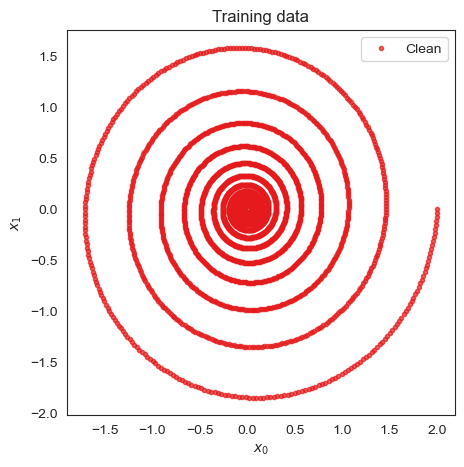

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(x_train[:, 0], x_train[:, 1], '.', label="Clean", color=pal[0], **plot_kws)
ax.set(title='Training data', xlabel='$x_0$', ylabel='$x_1$')
ax.legend()
fig.show()

#### 2. Build a Library of candidate terms that can describe the dynamics of the data

In [40]:
poly_order = 5
Theta = ps.PolynomialLibrary(degree=poly_order)
Theta

PolynomialLibrary(degree=5)

#### 3. Apply a Sparse Optimisation Method

In this example, we will apply the algorithm Sequential Threshold Least-Squares. We will set the threshold to 0.05

In [41]:
optimizer = ps.STLSQ(threshold=0.05)
optimizer

STLSQ(threshold=0.05)

#### 4. Choose a Differentiation Function

In [ ]:
diff = ps.FiniteDifference()

#### 5. Run SINDy

In [42]:
# apply SINDy for cleaned data

model = ps.SINDy(
    optimizer=optimizer,
    feature_library=Theta,
    #differentiation_method=diff,
    feature_names=["x", "y"]
)
model.fit(x_train, t=time_step)
equations = model.equations()
print_equations(equations)

                               x0=-0.100 x + 2.000 y                   
                               x1=-2.000 x + -0.100 y                  
-------------------------------------------------------------------------------------------


#### 6. Simulate Model

The learned model can be used to evolve initial conditions forward in time. Here we plot the trajectories predicted by the SINDy model against those of the true governing equations.

In [43]:
# Simulate 
x_sim = model.simulate(x0_train, t_train)
x_sim

array([[ 2.        ,  0.        ],
       [ 1.99760186, -0.03995475],
       [ 1.9944084 , -0.07981369],
       ...,
       [-0.00643355,  0.03620326],
       [-0.00570259,  0.03628838],
       [-0.00497081,  0.03635879]])

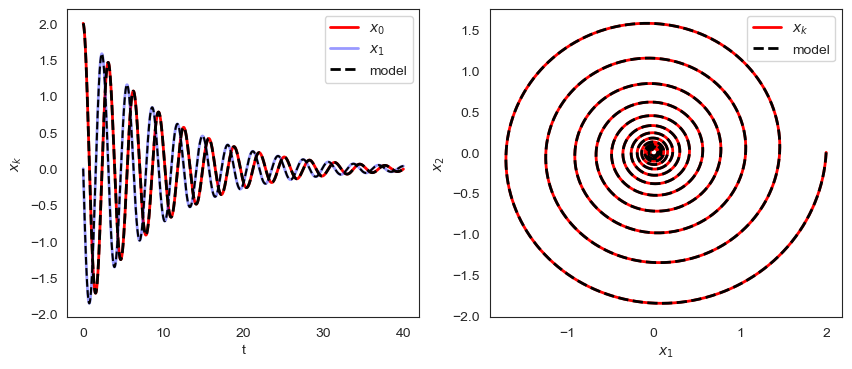

In [44]:
# plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Linear 3D ODE

Our final example of this section shows the application of SINDy to identify of a linear system in three dimensions. The governing equations are given by the following system.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix} $$

#### 1. Generate Samples

In [45]:
from pysindy.utils import linear_3D

dt = 0.01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0, 1]
x_train = solve_ivp(linear_3D, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_train

array([[ 2.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.99760141e+00, -3.99573560e-02,  9.97004496e-01],
       [ 1.99440741e+00, -7.98188709e-02,  9.94017964e-01],
       ...,
       [ 1.12240506e-02,  7.53082208e-03,  3.08667868e-07],
       [ 1.13610455e-02,  7.29754872e-03,  3.07743252e-07],
       [ 1.14932157e-02,  7.06181815e-03,  3.06821405e-07]])

#### 2. Build a Library of candidate terms that can describe the dynamics of the data

In [46]:
Theta = ps.PolynomialLibrary(degree=5)
Theta

PolynomialLibrary(degree=5)

#### 3. Choose a Sparse Optimisation Method


In [47]:
optimizer = ps.STLSQ(threshold=0.01)
optimizer

STLSQ(threshold=0.01)

#### 4. Choose a Differentiation Function

In [ ]:
diff = ps.FiniteDifference()

#### 5. Run SINDy

In [48]:
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=Theta,
    #differentiation_method=diff,
    feature_names=["x", "y", "z"]
)
model.fit(x_train, t=dt)
equations = model.equations()
print_equations(equations)

                               x0=-0.100 x + 2.000 y                   
                               x1=-2.000 x + -0.100 y                  
                               x2=-0.300 z                             
-------------------------------------------------------------------------------------------


#### 6. Simulate Model


In [49]:
x_sim = model.simulate(x0_train, t_train)
x_sim

array([[ 2.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.99760186e+00, -3.99547521e-02,  9.97004491e-01],
       [ 1.99440840e+00, -7.98136872e-02,  9.94017955e-01],
       ...,
       [ 1.11853760e-02,  7.61197524e-03,  3.08661051e-07],
       [ 1.13240312e-02,  7.37939350e-03,  3.07736454e-07],
       [ 1.14578736e-02,  7.14432067e-03,  3.06814627e-07]])

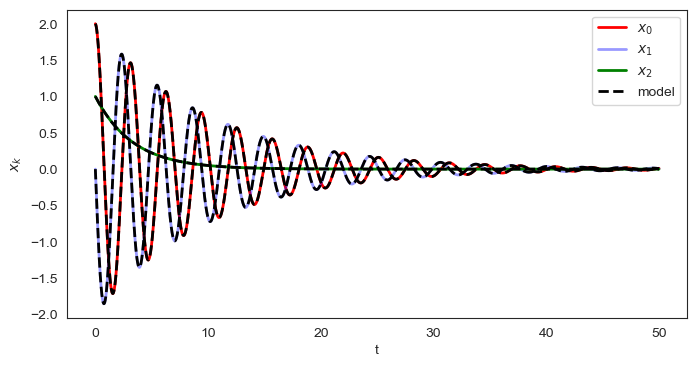

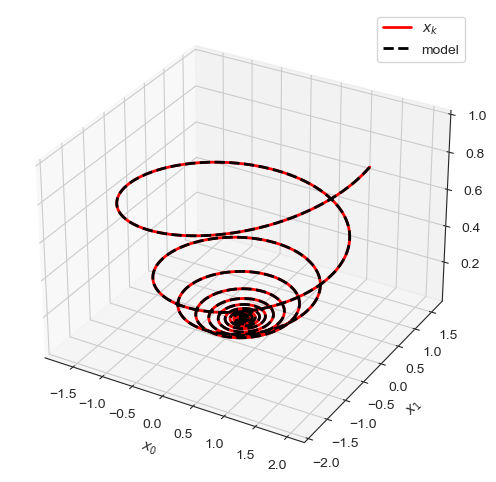

In [50]:
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(8, 4))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

### Lorenz System - Non Linear



#### 1. Generate Samples

In [51]:
from pysindy.utils import lorenz

# Generate measurement data
dt = .002
noise_level = 0.5

t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

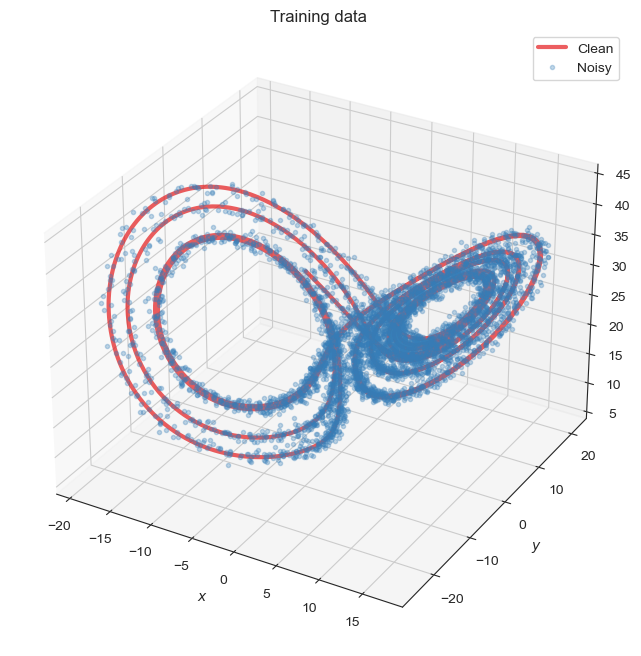

In [52]:
NOISE = 0.5
dt, t_train, x_train, x_train_noisy = gen_data_lorenz(NOISE, integrator_keywords)

fig = plt.figure(figsize=(8, 8))
plot_lorenz(x_train, x_train_noisy)
fig.show()

#### 2. Build a Library of candidate terms that can describe the dynamics of the data

In [53]:
Theta = ps.PolynomialLibrary(degree=5)
Theta

PolynomialLibrary(degree=5)

#### 3. Select Optimizer

In [75]:
optimizer = ps.STLSQ(threshold=0.05)
optimizer

STLSQ(threshold=0.05)

#### 4. Select Differentiation Function

In [70]:
diff = ps.FiniteDifference()

#### 5. Run SINDy

In [67]:
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=Theta,
    #differentiation_method=diff,
    feature_names=["x", "y", "z"]
)
model.fit(x_train, t=dt)
equations = model.equations()
print_equations(equations)


                               x0=-9.999 x + 9.999 y                   
                               x1=27.992 x + -0.999 y + -1.000 x z     
                               x2=-2.666 z + 1.000 x y                 
-------------------------------------------------------------------------------------------


#### 6. Simulate Model

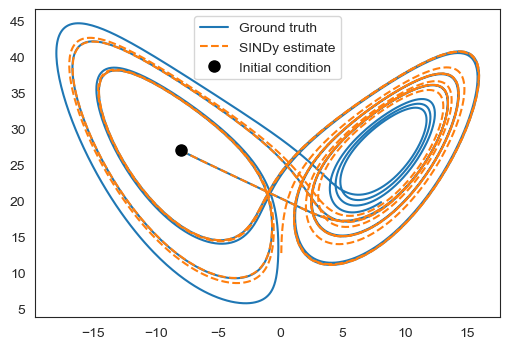

In [68]:
x_sim = model.simulate(x_train[0], t_train)

plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x0_train[0], x0_train[2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

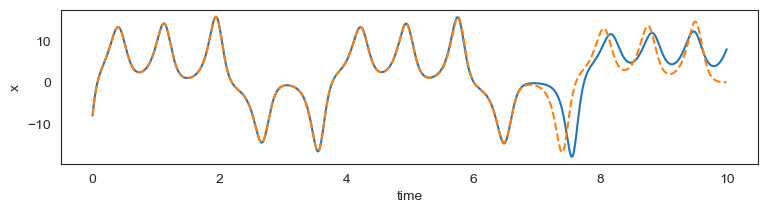

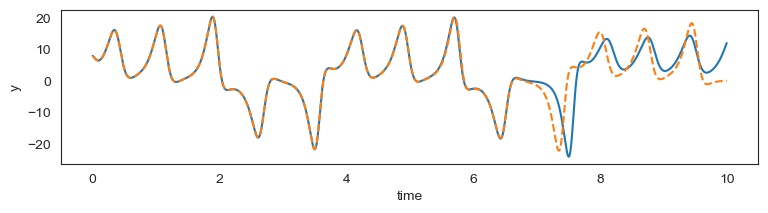

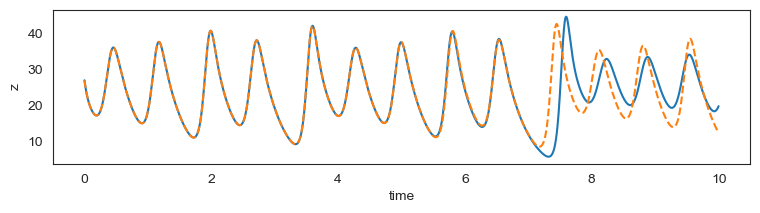

In [69]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(t_train, x_train[:, dim])
    ax.plot(t_train, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

#### 7. Run SINDy on Noisy data

In [76]:
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=Theta,
    differentiation_method=diff,
    feature_names=["x", "y", "z"]
)
model.fit(x_train_noisy, t=dt)
equations = model.equations()
print_equations(equations)

                               x0=3.731 1 + -9.825 x + 9.926 y + -0.257 z + 0.108 x^2 + -0.156 x y + 0.064 y^2
                               x1=13.089 1 + 24.830 x + 0.978 y + -1.757 z + -0.244 x^2 + 0.158 x y + -0.916 x z + -0.050 y z + 0.055 z^2
                               x2=-2.335 1 + 0.101 x + -0.068 y + -2.586 z + 0.060 x^2 + 0.813 x y + 0.101 y^2
-------------------------------------------------------------------------------------------


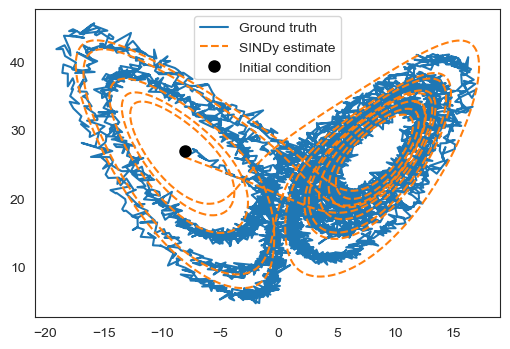

In [77]:
x_sim = model.simulate(x_train_noisy[0], t_train)

plt.figure(figsize=(6, 4))
plt.plot(x_train_noisy[:, 0], x_train_noisy[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x0_train[0], x0_train[2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

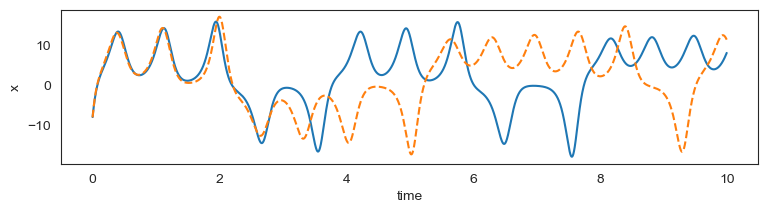

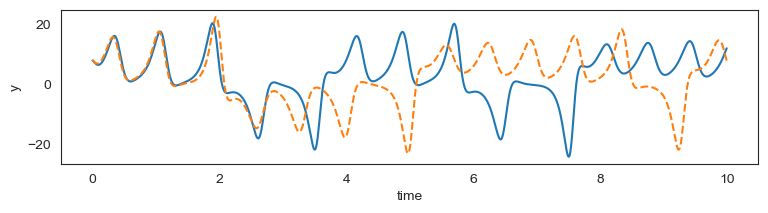

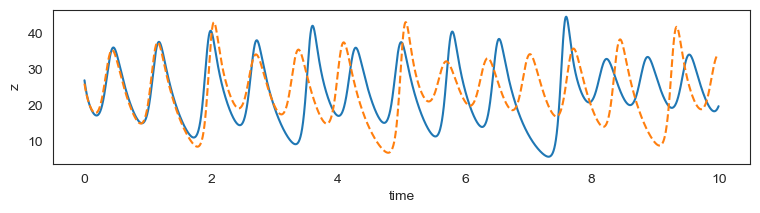

In [78]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(t_train, x_train[:, dim])
    ax.plot(t_train, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)
    
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

#### Another Example

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Dynamical_Neural_Networks/Complete_DNN_2_1.html


In [79]:
from scipy.integrate import odeint

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

In [80]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2),
)

model.fit(x_train, t=dt)

x_sim = model.simulate(x_train[0], time_steps)
print_equations(model.equations())


                               x0=-9.977 x0 + 9.977 x1                 
                               x1=27.807 x0 + -0.962 x1 + -0.995 x0 x2 
                               x2=-2.659 x2 + 0.997 x0 x1              
-------------------------------------------------------------------------------------------


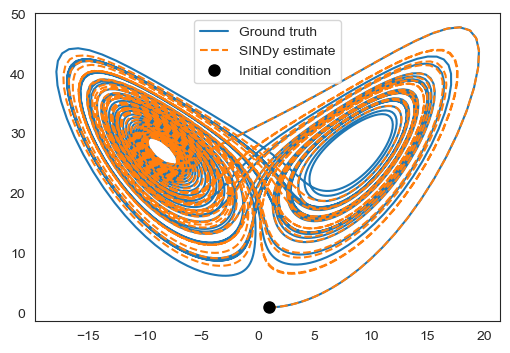

In [81]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

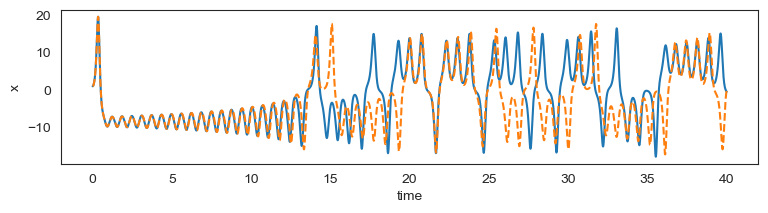

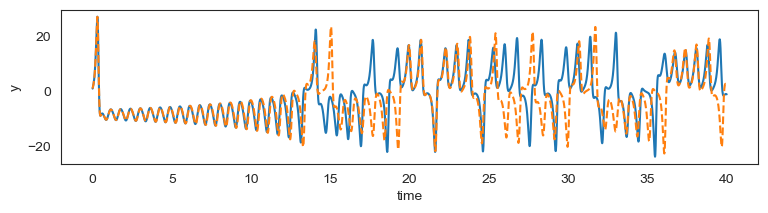

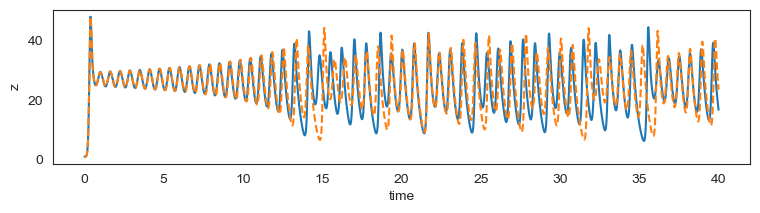

In [82]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)
    
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')